## Advanced Lane Finding 

### Camera Calibration Using Chessboard Images

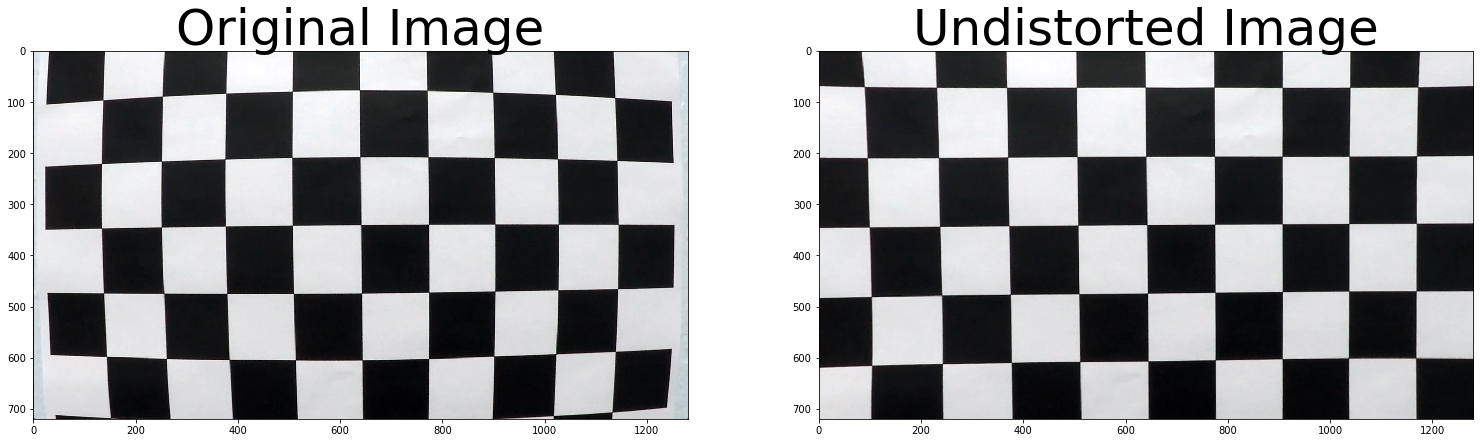

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# object points, like (0,0,0), (1,0,0), (2,0,0) ...
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

obj_points = [] # Real world 3D points
img_points = [] # "fake" 2d points

# Reading calibrationImages

#read the list of image paths
calibImagePaths = glob.glob('camera_cal/calibration*.jpg')

for image_path in calibImagePaths:
    img = cv2.imread(image_path)
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(grayImage, (9,6))
    
    if ret:
        obj_points.append(objp)
        img_points.append(corners)

# function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx);
    return undist

def displayUndistorted(image_path):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    #f.tight_layout()
    img=cv2.imread(image_path)
    ax1.imshow(img)
    ax1.set_title('OrigImage', fontsize=50)
    ax2.imshow(cal_undistort(img));
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

displayUndistorted(calibImagePaths[0]);    


### Test Image

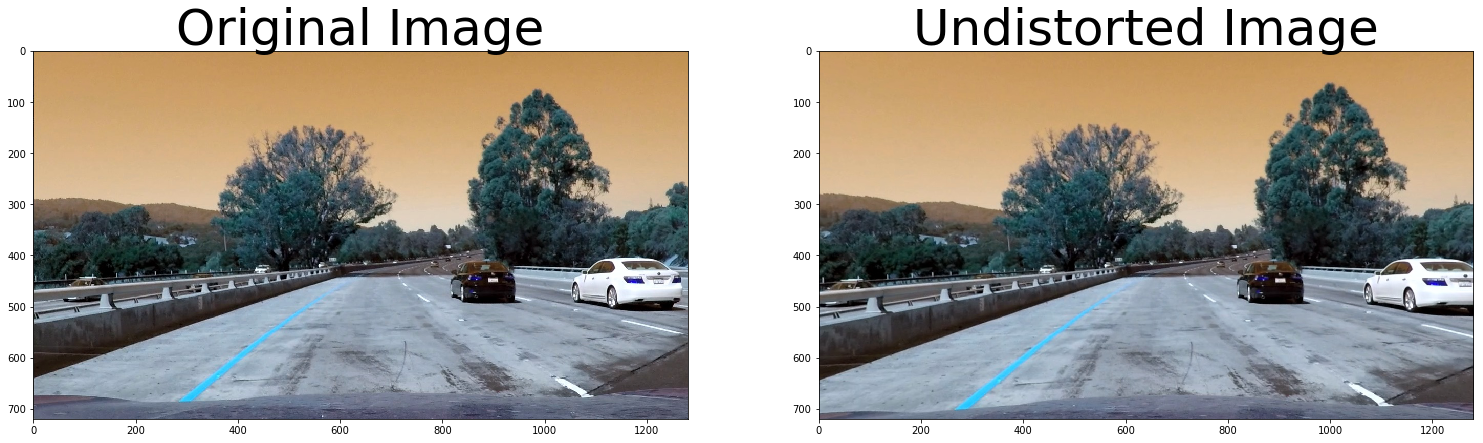

In [2]:
test_images = glob.glob('test_images/test*')
displayUndistorted(test_images[0])

## Thresholded Binary Image

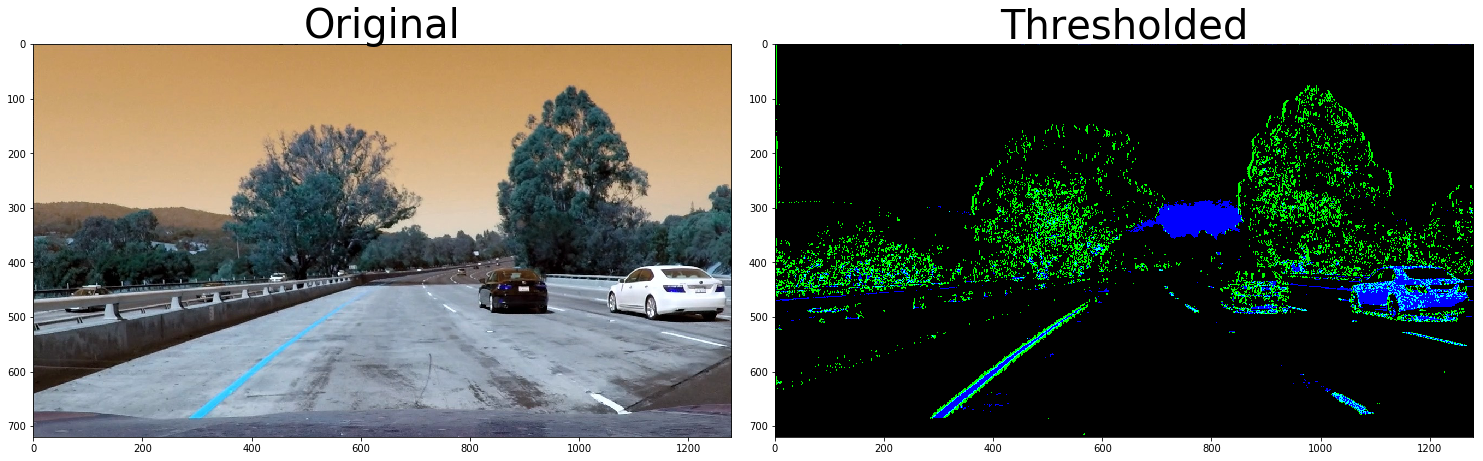

In [3]:
# From Classroom
def color_binaryThreshold(img, s_thresh=(200, 255), sx_thresh=(20, 100),l_thresh=(200,255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary=np.zeros_like(l_channel)
    l_binary[(l_channel >= s_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    combinedLS=np.zeros_like(l_channel);
    combinedLS[(l_binary == 1) | (s_binary == 1)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, combinedLS))
    return color_binary

def displayImages(original, updated,titleOriginal, titleModified):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()

    ax1.imshow(original)
    ax1.set_title(titleOriginal, fontsize=40)

    ax2.imshow(updated)
    ax2.set_title(titleModified, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

testImage = cv2.imread(test_images[0]);    
displayImages(testImage,color_binaryThreshold(testImage), "Original", "Thresholded")

## Perspective Transform

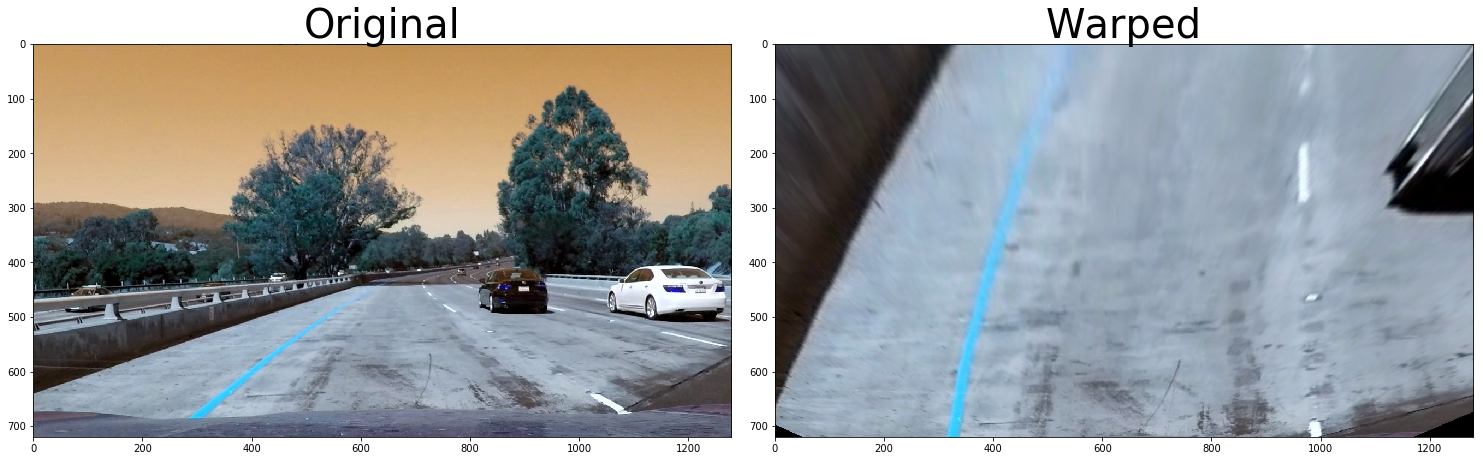

In [4]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    Minverse = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minverse;

h,w = testImage.shape[:2]

# define source and destination points for transform
src = np.float32([(560,460),
                  (700,460), 
                  (400,670), 
                  (950,670)])
##src = np.float32([
   ## [   0,   0], [1260,   0], 
  ##  [1260, 720], [   0, 720]
##])
##dst = np.float32([
  ##      [ 480, 485], [800, 485],
  #3      [1260, 690], [  0, 690]
  ##  ])
dst = np.float32([(400,0),
                  (w-400,0),
                  (400,h),
                  (w-400,h)])
warped,M, Minverse= unwarp(testImage,src,dst)
displayImages(testImage,warped,"Original","Warped");

### Undistored and Perspective Transform 

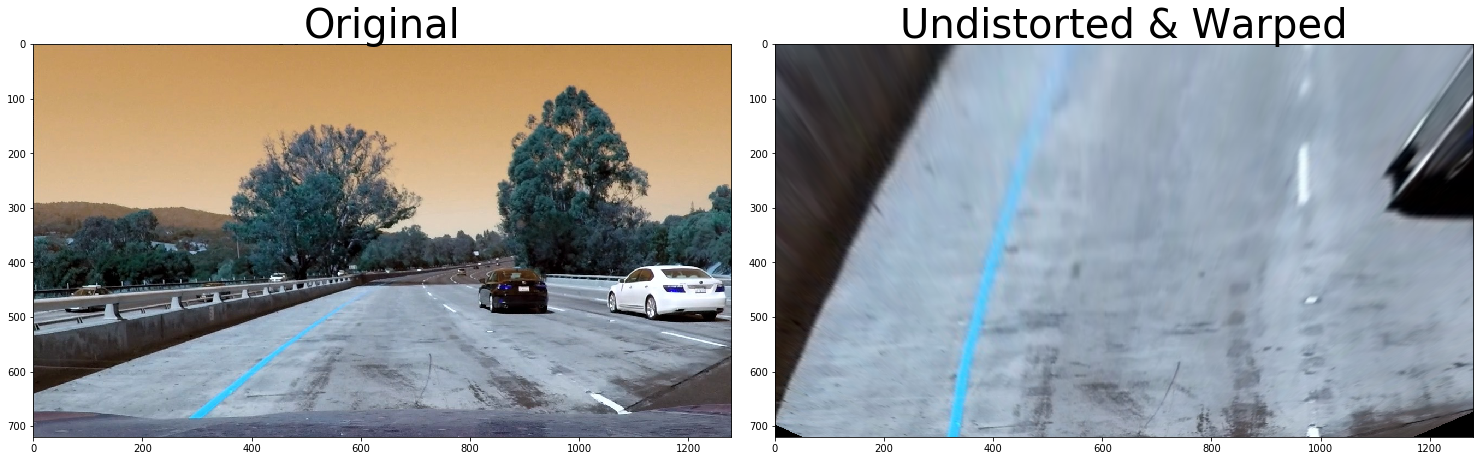

In [5]:

warped,M, Minverse= unwarp(cal_undistort(testImage),src,dst)
displayImages(testImage,warped,"Original","Undistorted & Warped");

### Perspective Transform on Undistorted BinaryThresholded Image

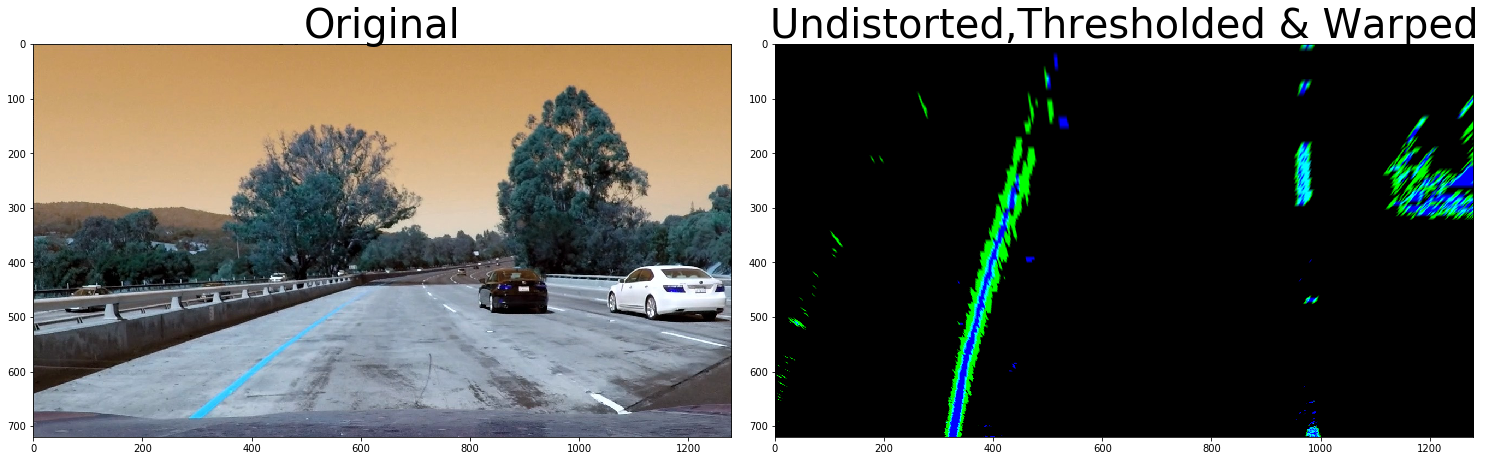

In [6]:
#testImage = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB)
warped,M,Minverse= unwarp(color_binaryThreshold(cal_undistort(testImage)),src,dst)
displayImages(testImage,warped,"Original","Undistorted,Thresholded & Warped");

### BinaryThreshold on Perspective Transform 

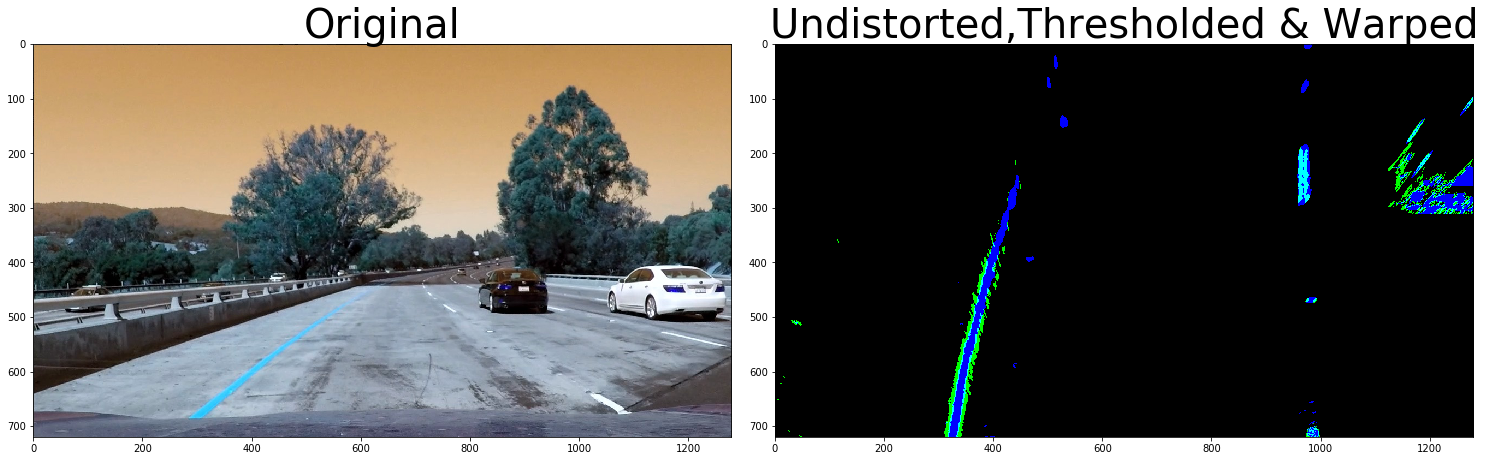

In [7]:
warped,M,Minverse= unwarp(cal_undistort(testImage),src,dst);
threshWarped=color_binaryThreshold(warped)
displayImages(testImage,threshWarped,"Original","Undistorted,Thresholded & Warped");

## Detect lane pixels and fit to find the lane boundary.

In [8]:
## From the notes
import matplotlib.image as mpimg
def slidingWindowLineDetection(binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #binary_warped = np.uint8(binary_warped)
    #binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_HSV2GRAY)
    #binary_warped=binary_warped[:,:,1]
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram);
    # Create an output image to draw on and  visualize the result
   # print(binary_warped.shape)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #print(out_img.shape)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    #leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    #rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
       # print(out_img.shape,win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2); 
   
        #cv2.rectangle(out_img,(660, 320),(740,360),(0,255,0),1); 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2); 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:    
        right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds,right_lane_inds,left_fit, right_fit,out_img

### Visualization of Rectangles

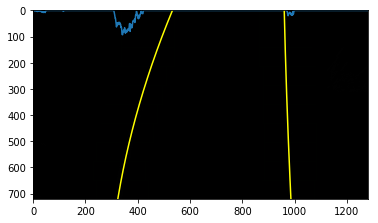

In [9]:
def visualizeRectangles(binary_warped,left_lane_inds,right_lane_inds,left_fit, right_fit,out_img):
    # Generate x and y values for plotting
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
   ## if left_fit is None or right_fit is None:
     ##   return;
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
#print(threshWarped.shape)
threshWarped=threshWarped[:,:,1]
left_lane_inds,right_lane_inds,left_fit, right_fit,out_img=slidingWindowLineDetection(threshWarped);
visualizeRectangles(warped,left_lane_inds,right_lane_inds,left_fit, right_fit,out_img);


#### Using Previous Fit 

In [10]:
def usingLastFitData(binary_warped,left_fit,right_fit):
        # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    #binary_warped=binary_warped[:,:,1]
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    print("lef_lane_inds",left_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new,right_fit_new = (None,None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx_new = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx_new = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds,left_fitx_new,right_fitx_new

#### Visualization 

In [11]:
def visualizeWithLastFit(binary_warped,left_lane_inds,right_lane_inds,left_fitx,right_fitx):
    
# Create an image to draw on and an image to show the selection window
    margin = 80
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

lef_lane_inds [False False False ...,  True  True False]


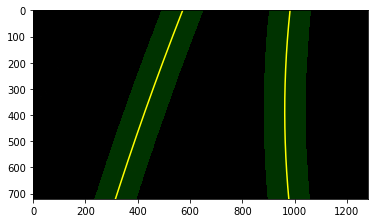

In [12]:
testImage2 = cv2.imread(test_images[2]);
warped2,M,Minverse= unwarp(cal_undistort(testImage2),src,dst);
threshWarped2=color_binaryThreshold(warped2)
threshWarped2=threshWarped2[:,:,1]
left_fit, right_fit, left_lane_inds, right_lane_inds,left_fitx,right_fitx=usingLastFitData(threshWarped2,left_fit,right_fit)
visualizeWithLastFit(threshWarped2,left_lane_inds, right_lane_inds,left_fitx,right_fitx)

### Radius of Curvature and Position of Vehicle wrt center

In [13]:
def radiusOfCurvature(binary_warped,left_lane_inds, right_lane_inds,left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    height = binary_warped.shape[0]
    ploty = np.linspace(0, height-1, height)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    y_eval = np.max(ploty)
    
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
        # Distance from center is image x midpoint - 
    if right_fit is not None and left_fit is not None:
        car_position = binary_warped.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

left_curverad, right_curverad, center_dist=radiusOfCurvature(threshWarped2,left_lane_inds, right_lane_inds,left_fit, right_fit)
print('Radius of curvature',left_curverad, 'm', right_curverad, 'm')
print('Center of distance',center_dist,'m')

Radius of curvature 3328.16000859 m 1192.20224248 m
Center of distance -0.033693692628 m


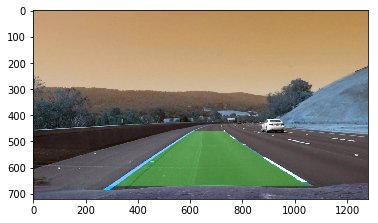

In [14]:
def drawBackLane(image, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(image)
    if left_fit is None or right_fit is None:
        return image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.3, 0)
    return result

result=drawBackLane(testImage2,threshWarped2,left_fit,right_fit,Minverse)
plt.imshow(result)

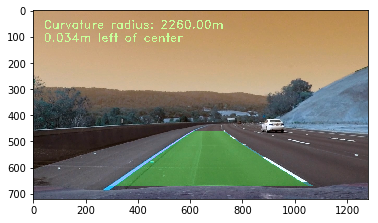

In [15]:
def drawDataonImage(image, curverad,center_dist):
    new_img = np.copy(image)
    h = new_img.shape[0]
    text = 'Curvature radius: ' + '{:.2f}'.format(curverad) + 'm'
    cv2.putText(new_img, text, (40,70), fontFace=2, fontScale=1.5, color=(200,255,155), thickness=2)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), fontFace=2,fontScale= 1.5, color=(200,255,155), thickness=2)
    return new_img

result2=drawDataonImage(result,int((left_curverad+right_curverad)/2),center_dist)
plt.imshow(result2)

### Line Definition 
To track previous fit..

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def lineFit(self, fit, inds):
        # add a fit to the line
        if fit is not None:
            #print(self.best_fit)
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
    
        print("lineFit",self.best_fit)

### Pipeline 

In [21]:
def handleImage(image):
    h,w = image.shape[:2]

    
    dst = np.float32([(400,0),
                      (w-400,0),
                      (400,h),
                      (w-400,h)])
    new_img = np.copy(image)
    warped,M,Minverse= unwarp(cal_undistort(image),src,dst);
    threshWarped=color_binaryThreshold(warped)
    threshWarped=threshWarped[:,:,1]
    #left_fit,right_fit=(None,None)
    # if both left and right lines were detected last frame,
    if not leftLine.detected or not rightLine.detected:
        left_lane_inds,right_lane_inds,left_fit, right_fit,out_img=slidingWindowLineDetection(threshWarped);
        visualizeRectangles(threshWarped,left_lane_inds,right_lane_inds,left_fit, right_fit,out_img);
    else:
        print("leftbestfit")
        left_fit, right_fit, left_lane_inds, right_lane_inds ,left_fitx,right_fitx=usingLastFitData(threshWarped,leftLine.best_fit, rightLine.best_fit)
    
    if left_fit is not None and right_fit is not None:
        h = image.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        #if abs(350 - x_int_diff) > 100:
         #   left_fit = None
          #  right_fit = None
         
    #print(left_fit,right_fit)
    leftLine.lineFit(left_fit, left_lane_inds)
    rightLine.lineFit(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if leftLine.best_fit is not None and rightLine.best_fit is not None:
        output1 = drawBackLane(new_img, threshWarped, leftLine.best_fit, rightLine.best_fit, Minverse)
        left_curverad, right_curverad, center_dist = radiusOfCurvature(threshWarped, left_lane_inds,
                                               right_lane_inds,leftLine.best_fit, rightLine.best_fit)
        output2 = drawDataonImage(output1, (left_curverad+right_curverad)/2, center_dist)
    else:
        output2 = new_img
    return output2;    

In [23]:
left_Line=Line();
right_Line=Line();
# define source and destination points for transform
src = np.float32([(560,460),
                  (700,460), 
                  (400,670), 
                  (950,670)])

clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(ja) 
video_clip.write_videofile('result.mp4', audio=False)

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

NameError: name 'pipeline' is not defined